# Support Vector Machine: Classify newsgroup from text

# Setup and Vocabulary Selection

Below is the code needed to load the data and select the vocabulary that we will use in the Support Vector Machine model. We only use the top 5000 words that occurred at least 10 times.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import sklearn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from numpy.polynomial.polynomial import polyfit
from math import sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import itertools

In [4]:
#read in files
mydata=pd.read_csv("http://ana.cachopo.org/datasets-for-single-label-text-categorization/20ng-train-all-terms.txt", sep="\t*",header=None, names=['title','blog'])
testdata=pd.read_csv("http://ana.cachopo.org/datasets-for-single-label-text-categorization/20ng-test-all-terms.txt", sep="\t*",header=None, names=['title','blog'])


C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\ebish\Anaconda3\lib\site-packages\pandas\io\parsers.py:2230: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\ebish\Anaconda3\lib\site-packages\pandas\io\parsers.py:2232: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\ebish\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Here we are making decisions on how to pick our 5000 vocabulary words. First, I vectorized our words and said I only wanted them if the word appeared at least 10 or more times. This helped decreased our list size from 73,000 to about 13,000. Then with this I found the mutual information of those 13,000 and picked the top 5000 words to be part of our vocabulary list.

In [3]:
#vectorize the training dataset and check shape
vectorizer=CountVectorizer(binary=True, min_df=10)
clean_set=mydata['blog']
y_clean=mydata['title']
x_traincv=vectorizer.fit_transform(clean_set)
x_array_clean=x_traincv.toarray()
print(x_array_clean.shape)
print(y_clean.shape)

(11293, 13414)
(11293,)


In [5]:
#compute mutual information 
mi=mutual_info_classif(x_array_clean, y_clean)

In [77]:
#output the top 10 features with the highest mutual information value
indices=np.argsort(mi)[::-1]
features=vectorizer.get_feature_names()
top_n=5000
dic=[features[i] for i in indices[:top_n]]
top_features=[(features[i], mi[i]) for i in indices[:top_n]]
df=pd.DataFrame(top_features)
df.columns=['feature','Mutual Information Value']
df.head(10)

,feature,Mutual Information Value
0,windows,0.121171
1,god,0.102437
2,dod,0.093079
3,clipper,0.083593
4,sale,0.081725
5,re,0.080449
6,bike,0.080105
7,we,0.078501
8,encryption,0.077379
9,he,0.077090


Here we have the top 10 words and their mutual information. We see that the most informative word is windows. 

In [78]:
#the bottom 10 featuers with the lowest mutual information value
df.tail(10)

,feature,Mutual Information Value
4990,dm,0.005727
4991,cooperating,0.005725
4992,astronomy,0.005724
4993,saw,0.005724
4994,request,0.005722
4995,solntze,0.005722
4996,neat,0.005721
4997,advisory,0.005719
4998,minute,0.005719
4999,correction,0.005718


Here we have the last 10 words and their mutual information. Here we see that we pass our sanity check since all our mutual information values are greater than zero and less than log2(20).

# Input Representation and Classifier

Here we choose three different ways to represent a document as a vector. We use 1. raw counts where each entry in the feature vector holds the count of the word in the document 2. binary indicator variables where each entry in the vector is 1 if it occurs at all in the document and 0 otherwise 3. log-normalized counts where each entry becomes log(number of occurences of term t in document d + 1).

Also, I chose to have a validation data set to be able to work with hyperparameters. I chose to have the validation data set be 20% of the training dataset because that is usually the standard of what to make the validation set. 

In [8]:
#split data sets into X and Y components 
X=mydata.iloc[:,1:2]
y=mydata.iloc[:,0]
X_testdata=testdata.iloc[:,1:2]
y_testdata=testdata.iloc[:,0]
X_train, X_validate, y_train,y_validate=train_test_split(X,y,test_size=.20)


In [9]:
####binary representation 
vecbin=CountVectorizer(binary=True,vocabulary=dic)
x_trainvecbin=vecbin.fit_transform(X_train['blog'])
x_validate_bin=vecbin.transform(X_validate['blog'])
x_validate_bin=x_validate_bin.toarray()
x_array_bin=x_trainvecbin.toarray()

In [10]:
###raw count representation
veccount=CountVectorizer(vocabulary=dic)
x_trainveccount=veccount.fit_transform(X_train['blog'])
x_array_raw=x_trainveccount.toarray()
x_validate_count=veccount.transform(X_validate['blog'])
x_validate_count=x_validate_count.toarray()

In [11]:
###log-normalized counts, log(td+1)
x_train_log=[np.log(i+1) for i in x_array_raw]
x_validate_log=[np.log(i+1) for i in x_validate_count] 

Testing a model to make sure things are working

In [15]:
#test model
model_binary=svm.LinearSVC()
model_binary.fit(x_array_bin, y_train)
y_pred_bin=model_binary.predict(x_validate_bin)
accuracy_score(y_validate,y_pred_bin)

0.8193891102257637

In [16]:
print(classification_report(y_validate,y_pred_bin))

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.80      0.78        75
           comp.graphics       0.62      0.71      0.66       113
 comp.os.ms-windows.misc       0.70      0.74      0.72       112
comp.sys.ibm.pc.hardware       0.65      0.65      0.65       124
   comp.sys.mac.hardware       0.82      0.78      0.80       113
          comp.windows.x       0.77      0.79      0.78       121
            misc.forsale       0.76      0.80      0.78       122
               rec.autos       0.83      0.85      0.84       125
         rec.motorcycles       0.93      0.90      0.91       116
      rec.sport.baseball       0.87      0.87      0.87       117
        rec.sport.hockey       0.92      0.93      0.93       107
               sci.crypt       0.94      0.92      0.93       129
         sci.electronics       0.76      0.70      0.73       137
                 sci.med       0.86      0.87      0.87       116
         

Here we make a sanity check. The biggest group the in training dataset in rec.sports.hockey with 5.5% of the training data being part of that group. Our model above had a 81% accuracy rate which means that are model is doing something right since it is bigger than our baseline. 

In [17]:
##sanity check
sc=y_train.value_counts()/np.sum(y_train.value_counts())
sc

rec.sport.hockey            0.054572
rec.motorcycles             0.053354
rec.sport.baseball          0.053133
sci.med                     0.052911
sci.space                   0.052468
soc.religion.christian      0.052247
comp.windows.x              0.052247
comp.graphics               0.052136
rec.autos                   0.051915
sci.crypt                   0.051583
comp.sys.ibm.pc.hardware    0.051583
comp.sys.mac.hardware       0.051472
misc.forsale                0.051251
comp.os.ms-windows.misc     0.050919
sci.electronics             0.050255
talk.politics.mideast       0.049369
talk.politics.guns          0.047487
alt.atheism                 0.044831
talk.politics.misc          0.041842
talk.religion.misc          0.034426
Name: title, dtype: float64

Creating a function that tests different cvalues(penalty parameter of the error term) to find the best C value for our model.

In [23]:
def hyperparameters(cval, pen, du, x, y,v,yv,model):
#creating lists to hold our errors for each C value and
    prediction_val=[];
    prediction_train=[];
#for loop that loops through the c values to create a model that uses 
#that c value, then predicts values for the training and validation
#and then appends the error for training and validation. 
    for i in range(len(cval)):
        svc=svm.LinearSVC(penalty=pen,C=cval[i],dual=du)
        svct=svc.fit(x, y)
        y_pred_train_dummy=svct.predict(x)
        y_pred_validation_dummy=svct.predict(v)
        prediction_val=np.append(prediction_val,1-accuracy_score(yv, y_pred_validation_dummy))
        prediction_train=np.append(prediction_train,1-accuracy_score(y, y_pred_train_dummy))
        
    k=plt.plot(cval, prediction_val, '-o',c='red')
    t=plt.plot(cval, prediction_train,'-o', c='blue')
    plt.title('C vs. Error, Model='+model)
    plt.xlabel('C')
    plt.ylabel('Error Value')
    plt.legend(('Validation Dataset','Training Dataset'))
    plt.setp(k,markersize=4)
    plt.setp(t,markersize=4)
    return(prediction_val,prediction_train)

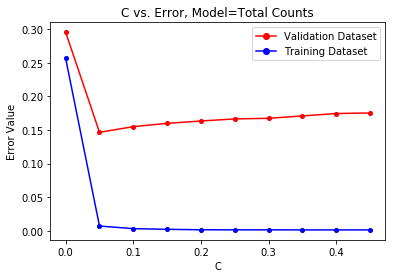

In [24]:
#total counts c vs error value
c=np.arange(.0001,.5,.05)
(pv_raw,pt_raw)=hyperparameters(cval=c, pen='l2',du=True,
                x=x_array_raw,y=y_train,v=x_validate_count,
                yv=y_validate,model='Total Counts')

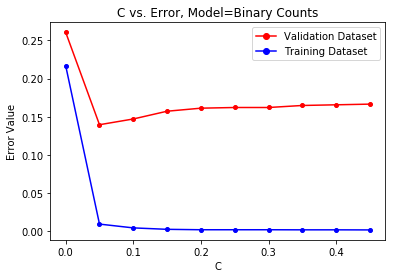

In [25]:
#binary counts c vs error values
c=np.arange(.0001,.5,.05)
(pv_bin,pt_bin)=hyperparameters(cval=c, pen='l2',du=True,
                x=x_array_bin,y=y_train,v=x_validate_bin,
                yv=y_validate,model='Binary Counts')

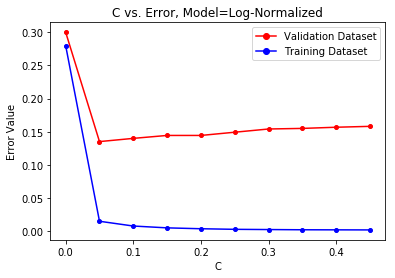

In [79]:
#log-normalized c vs error
c=np.arange(.0001,.5,.05)
(pv_log,pt_log)=hyperparameters(cval=c, pen='l2',du=True,
                x=x_train_log,y=y_train,v=x_validate_log,
                yv=y_validate,model='Log-Normalized')

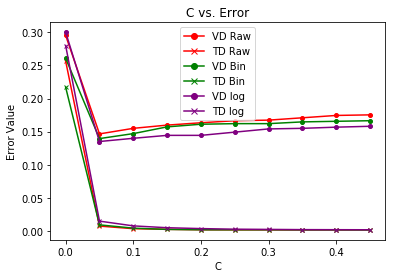

In [144]:
#plot all of them
k=plt.plot(c, pv_raw, '-o',c='red')
t=plt.plot(c, pt_raw,'-x', c='red')
s=plt.plot(c, pv_bin,'-o', c='green')
u=plt.plot(c, pt_bin,'-x', c='green')
v=plt.plot(c, pv_log,'-o', c='purple')
w=plt.plot(c, pt_log,'-x', c='purple')
plt.title('C vs. Error')
plt.xlabel('C')
plt.ylabel('Error Value')
plt.legend(('VD Raw','TD Raw','VD Bin','TD Bin','VD log','TD log'))
plt.setp(k,markersize=4)
plt.setp(t,markersize=4)
plt.setp(s,markersize=4)
plt.setp(u,markersize=4)
plt.setp(v,markersize=4)
plt.setp(w,markersize=4)
plt.savefig('t.jpg')

Here we have all the models with different C values. From this we see that the best model that minimizes the error is the log-normalized counts where C=0.05. Thus, we create our final model with the log-normalized counts.

# Evaluation

In [31]:
#creating our best model to use on test data
finalmodel=svm.LinearSVC(penalty='l2',C=0.05,dual=True)
finalmodel=finalmodel.fit(x_train_log, y_train)

In [33]:
#putting test data into correct format to test out
veccountest=CountVectorizer(vocabulary=dic)
x_testveccountest=veccountest.fit_transform(X_testdata['blog'])
x_array_test=x_testveccountest.toarray()
x_test_log=[np.log(i+1) for i in x_array_test]
y_pred_test=finalmodel.predict(x_test_log)

In [36]:
#test data accuracy score
accuracy_score(y_pred_test, y_testdata)

0.7623538788522848

Here created a function that creates a nice confusion matrix.

In [154]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[218   2   0   2   0   3   1   1   2   6   0   2   2   8   5  21   2   1
    2  41]
 [  2 259  17  12  11  34   6   5   1   6   1   2  18   2   4   2   1   2
    2   2]
 [  2  22 275  36  12  20   3   1   0   5   0   0   0   3   2   2   2   2
    3   4]
 [  0  20  32 256  28   3  12   4   0   1   0   3  28   3   1   0   0   0
    1   0]
 [  0  12   8  25 288   3  10   4   0   7   0   5  17   4   2   0   0   0
    0   0]
 [  1  36  35  15   3 264  14   2   1   1   0   3   6   2   5   0   3   0
    1   0]
 [  2   3   0  13  12   0 345   5   0   1   1   1   4   2   1   0   0   0
    0   0]
 [  1   4   1   8   3   1  12 326  10   4   0   0  11   6   1   1   3   0
    3   0]
 [  0   1   0   2   2   0   6  22 350   1   0   0   5   2   1   1   2   0
    2   1]
 [  2   0   1   3   2   2   6   2   0 349  16   2   1   3   1   2   1   0
    2   2]
 [  1   1   0   0   2   0   2   1   1  12 374   2   0   0   1   0   2   0
    0   0]
 [  0   4   1   1   2   2

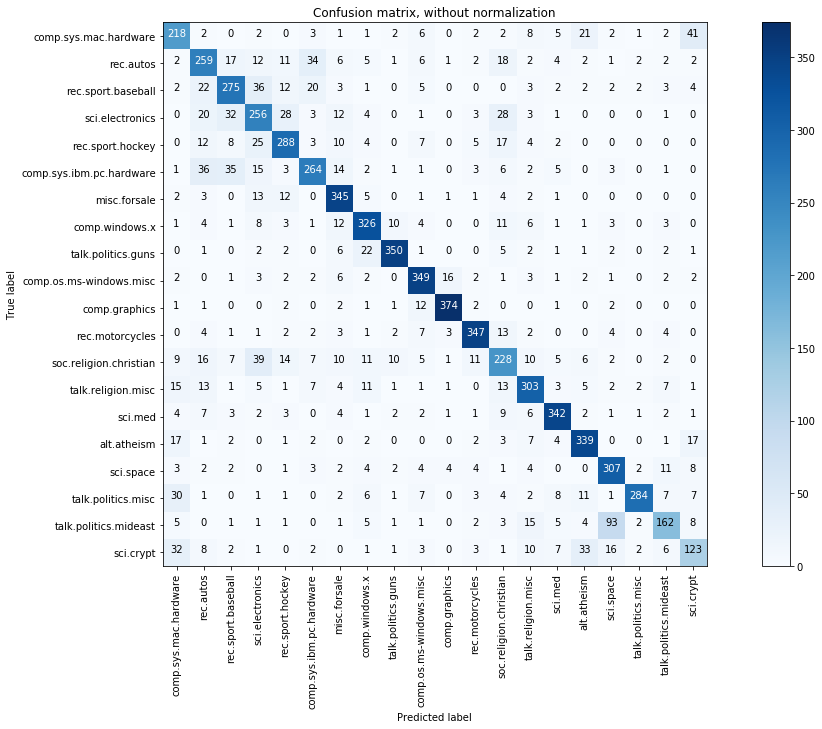

In [155]:
class_names=y_validate.unique()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testdata, y_pred_test);
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()


Here we get our confusion matrix. Our top 5 misclassifications are talk.politics.mideast/sci.space(93), comp.sys.mac.hardware/sci.crypt(41), 
soc.religion.christian/sci.electronics(39),
rec.sport.baseball/sci.electronics(36), and
comp.sys.ibm.pc.hardware/rec.autos(36).
The first topic is the true label while the second topic is what was predicted. For example, it misclassified the doucment from talk.politics.mideast as sci.space. I don't really see how all of these make sense. I was expecting soc.religion.christian to get misclassified as talk.religion.misc or alt.atheism or something that seemed to be a little more relevant and not electronics. Same with the very worst one with talk.politics.mideast/sci.space(93). What does space have to do with politics.mideast? To me, these were results were surprising. I didn't think these errors made sense given the topics. The only ones that make sense to me are comp.sys.mac.hardware/sci.crypt(41) and omp.sys.ibm.pc.hardware/rec.autos(36) which all seem to be related in the type of mechanical work each topic is. Other than that I was shocked by the top misclassifications. 

# Model Inspection

Here we take a look at the weights of our model to see if we can gain any insight into how our model is working.

In [158]:
def plot_coefficients(classifier, feature_names,i, top_features=10):
    coef = classifier.coef_[i].ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0,  2 * top_features), feature_names[top_coefficients], rotation=60, ha='center')
    plt.title('Top 10 and bottom 10 features with weight value for: '+finalmodel.classes_[i])
    plt.xlabel('Features')
    plt.ylabel('Weight Value')
    plt.show()
    



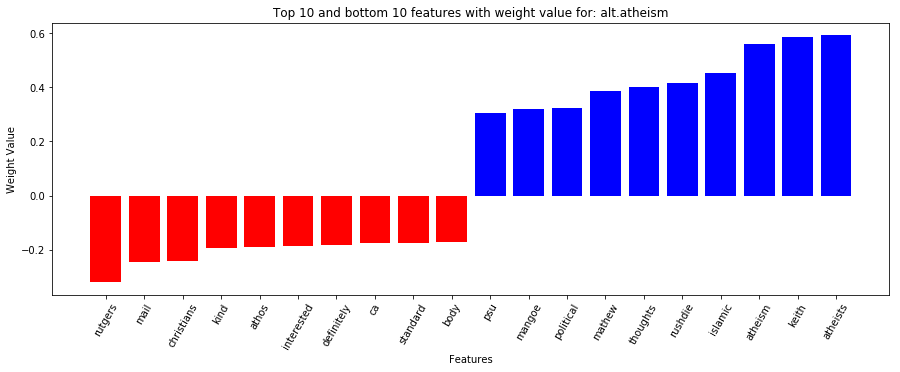

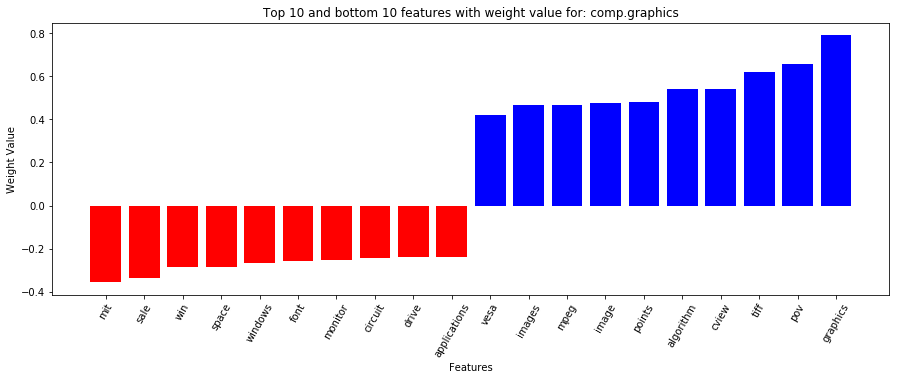

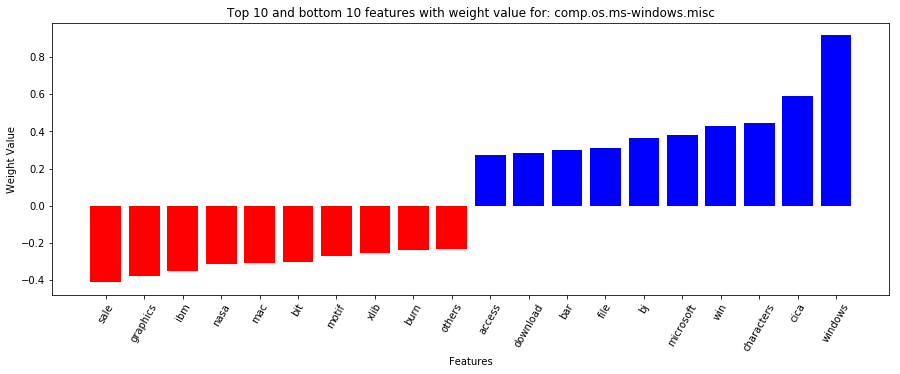

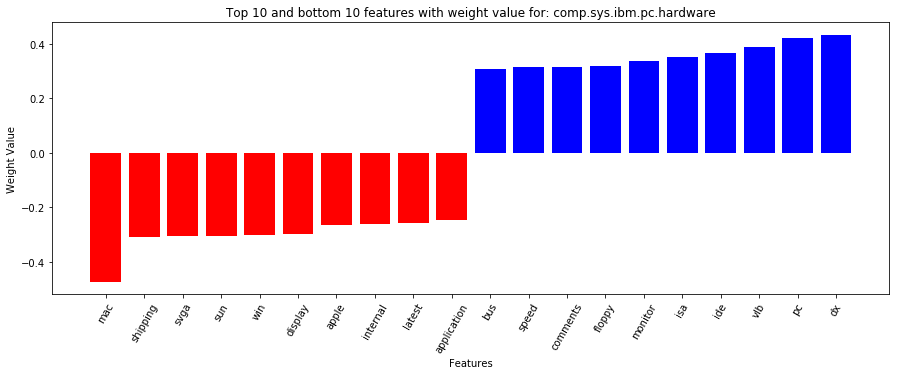

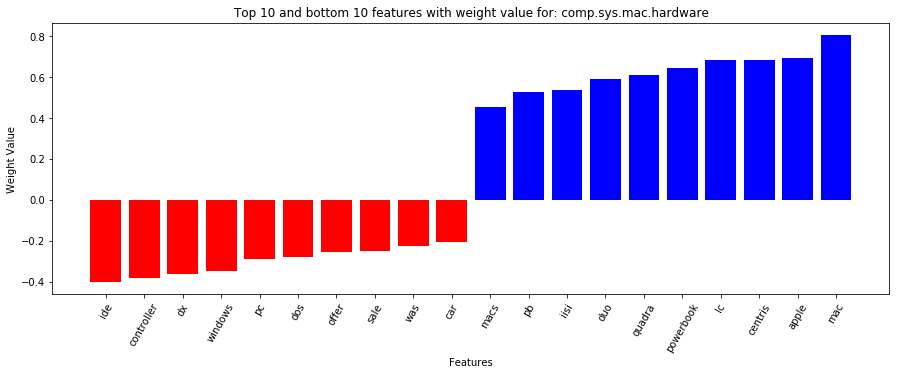

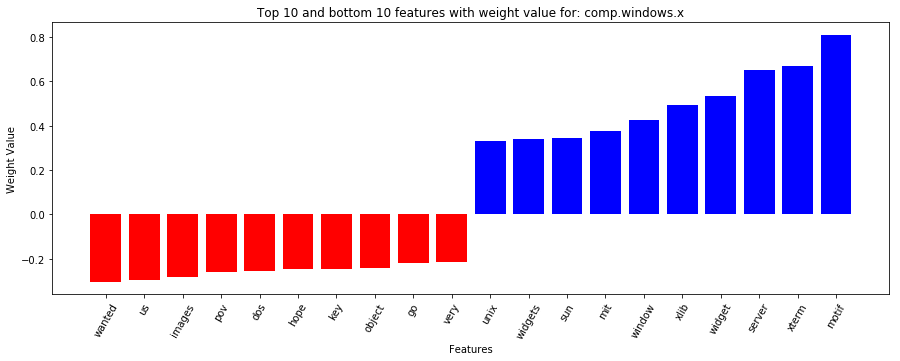

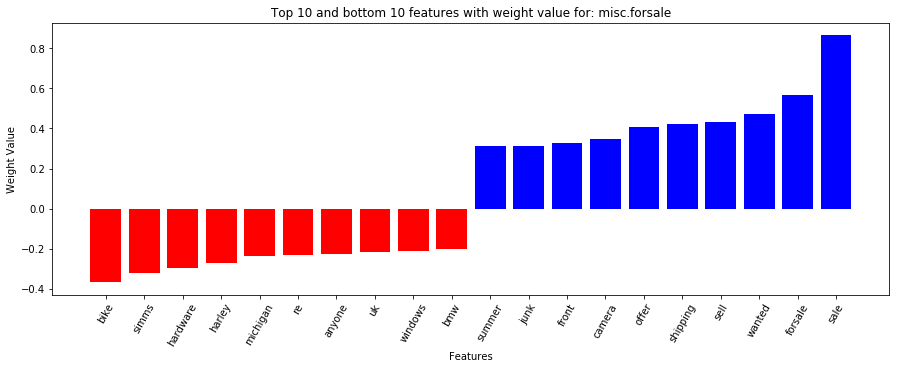

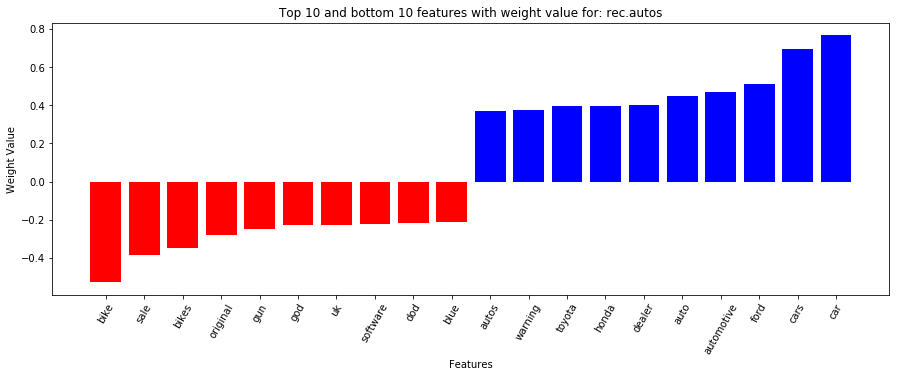

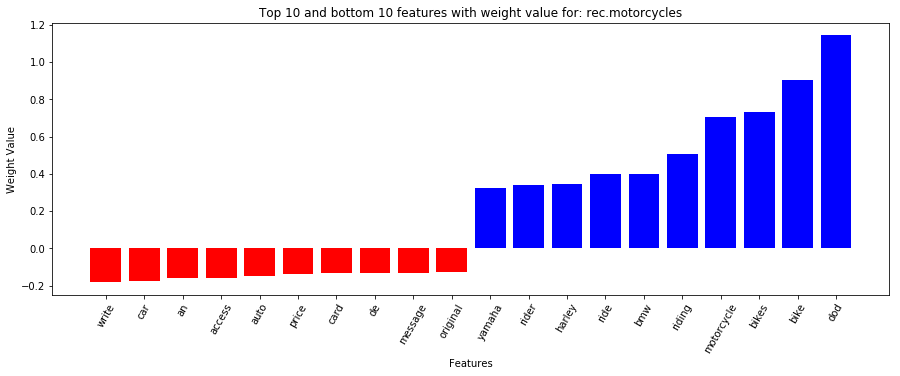

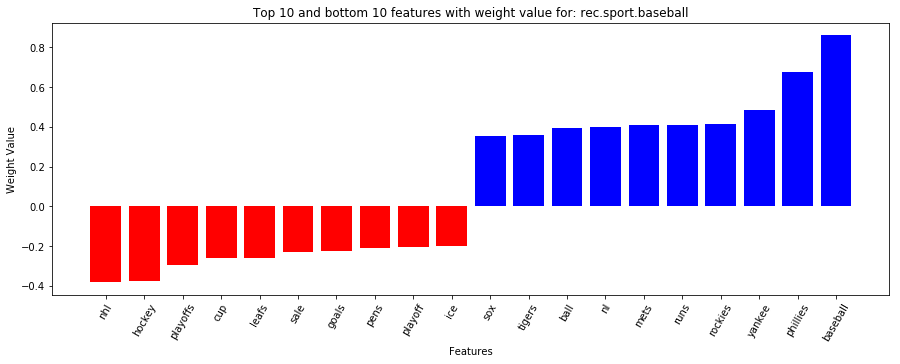

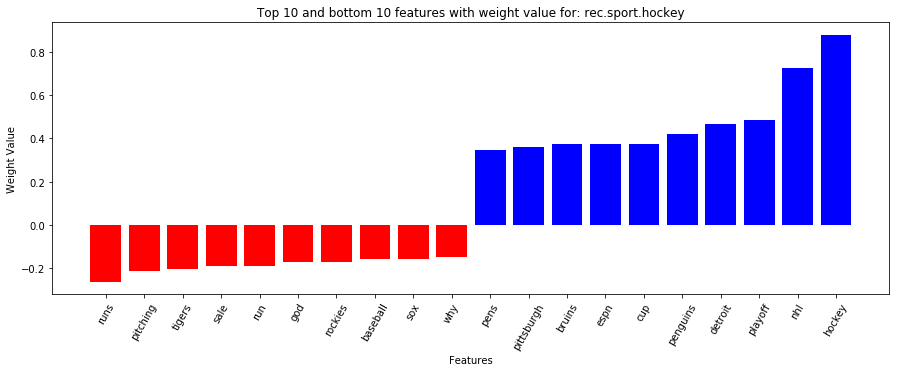

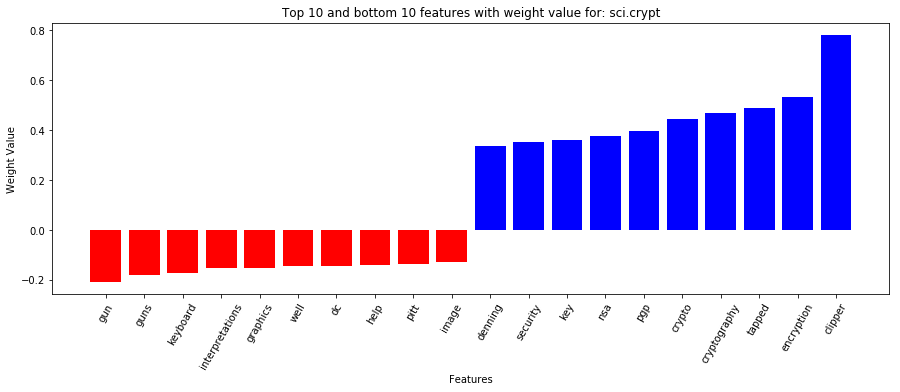

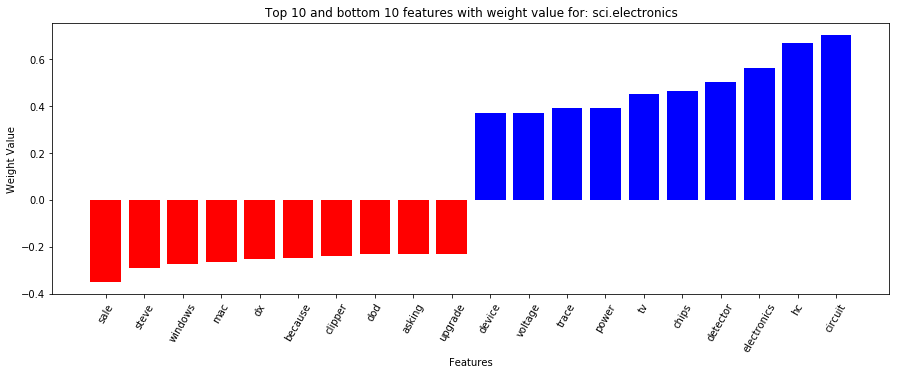

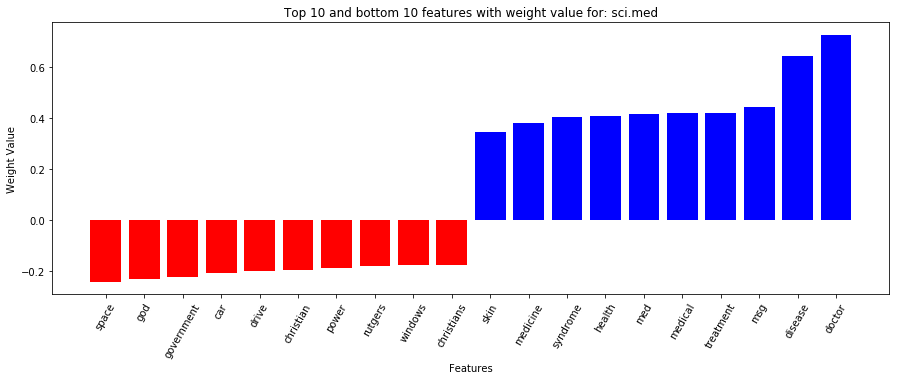

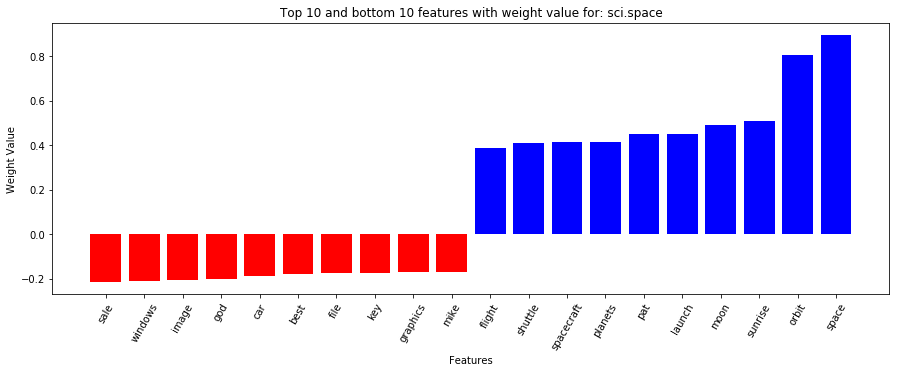

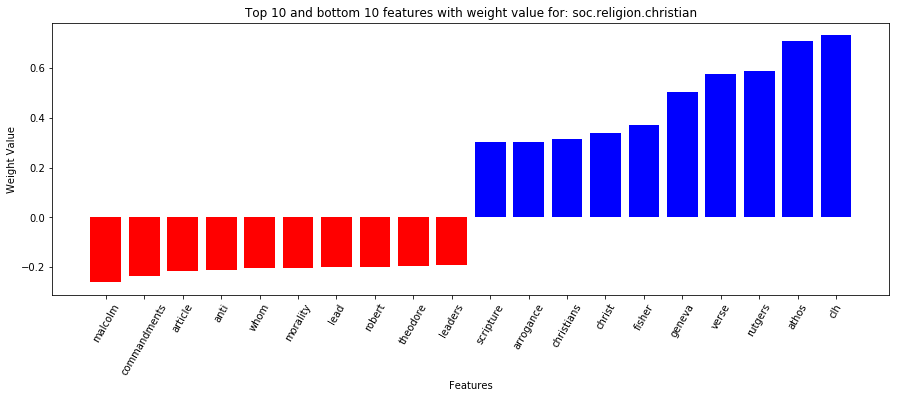

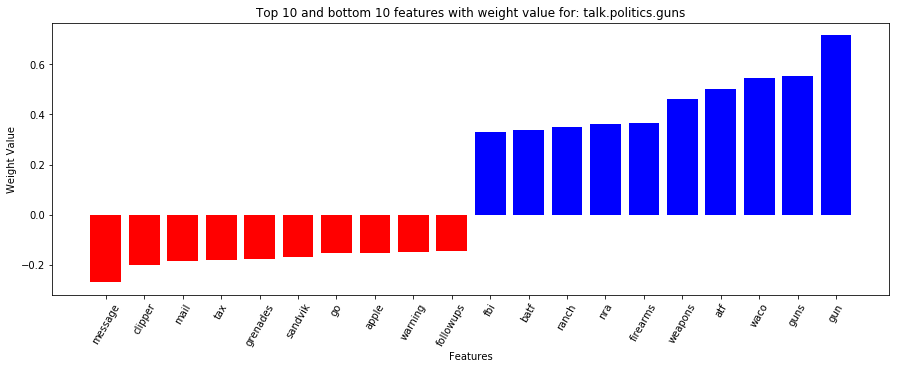

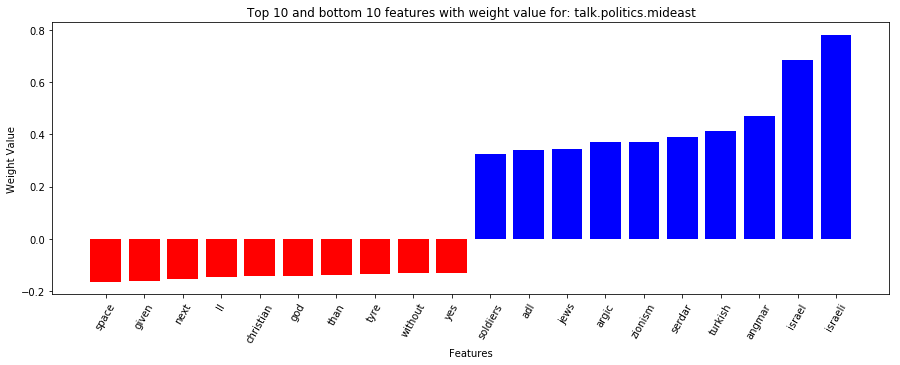

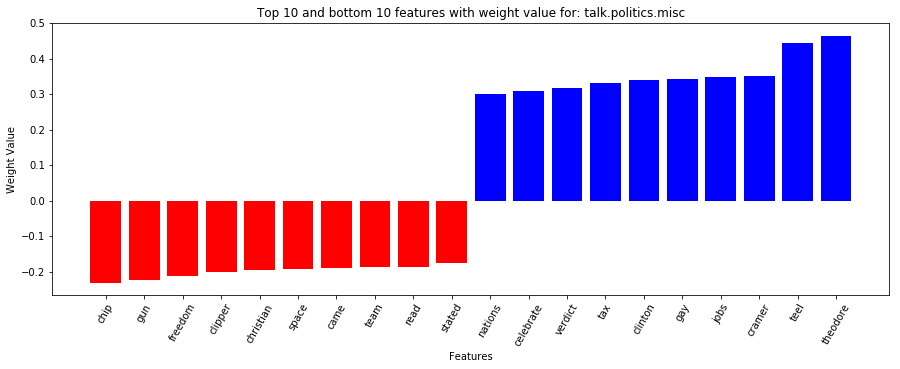

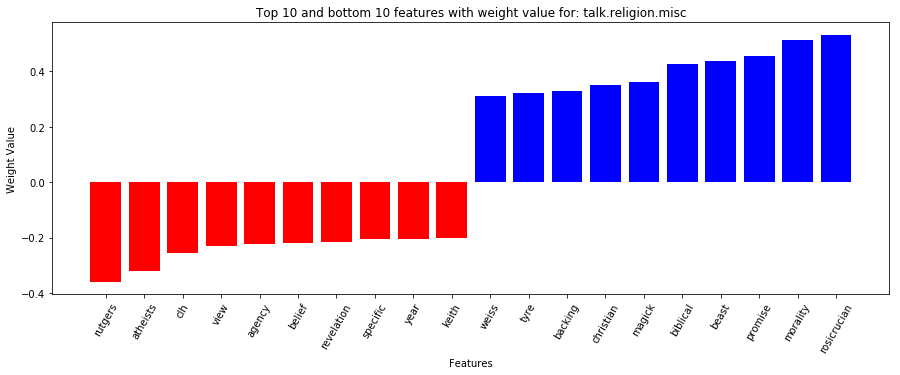

In [159]:
for j in range(20):
    plot_coefficients(finalmodel,dic,i=j)
    


It was very interesting to look at the top 10 and bottom 10 features for each topic. The top 10 mutual information words seem to appear quite frequently in the top 10 and bottom 10 featuers depending on the topic. This makes sense since the top 10 mutual information words are the words that are the most desicive words that help us determine topics. Also, it seemed that the top feature for each of the topics was a word that seemed overly descriptive of the topic. For example alt.atheism's top word was atheists and comp.graphics top word was graphics and so on. I also loved how comp.sys.mac.hardware's had 'windows' in one of its bottom words and comp.os.ms-windows.misc had 'mac' in its bottom words. Everything just seemed intuitive for the most part. 

Conclusion: Linear Support Vector Machine proved to be a useful model to use in our current dataset. Our best model was our log-normalized counts where our vocabulary consisted of the top 5000 words based off of their mutual information score. With this model our test dataset was scored with a 76.2% accuracy. We were able to explore the different weights of the model and determine that our mutual information score proved useful in knowing what features would have a stronger impact on determining on what topic to classify for each document. 